In [2]:
!wget -c https://repo.continuum.io/archive/Anaconda3-2019.03-Linux-x86_64.sh
!chmod +x Anaconda3-2019.03-Linux-x86_64.sh
!bash ./Anaconda3-2019.03-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y --prefix /usr/local -c <<<your wish>>>>

# Настройка conda
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-04-28 04:36:13--  https://repo.continuum.io/archive/Anaconda3-2019.03-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 685906562 (654M) [application/x-sh]
Saving to: ‘Anaconda3-2019.03-Linux-x86_64.sh’

Anaconda3-2019.03-L 100%[===================>] 654.13M  91.3MB/s    in 7.7s    

2019-04-28 04:36:20 (84.8 MB/s) - ‘Anaconda3-2019.03-Linux-x86_64.sh’ saved [685906562/685906562]

PREFIX=/usr/local
reinstalling: python-3.7.3-h0371630_0 ...
using -f (force) option
Python 3.7.3
reinstalling: conda-env-2.6.0-1 ...
using -f (force) option
reinstalling: blas-1.0-mkl ...
using -f (force) option
reinstalling: ca-certificates-2019.1.23-0 ...
using -f (force) option
reinstalling: intel-openmp-2019.3-199 ...
using -f (force) option
reinstalling: libgcc-ng-8.2.0-hdf63c60_1 ...
usi

In [3]:
!conda info
!conda install --yes numba
!conda install --yes cudatoolkit

# Настройка CUDA
import os
os.environ['NUMBAPRO_NVVM']      = r'/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = r'/usr/local/cuda-10.0/nvvm/libdevice/'


     active environment : None
       user config file : /root/.condarc
 populated config files : 
          conda version : 4.6.11
    conda-build version : 3.17.8
         python version : 3.7.3.final.0
       base environment : /usr/local  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/free/linux-64
                          https://repo.anaconda.com/pkgs/free/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /usr/local/pkgs
                          /root/.conda/pkgs
       envs directories : /usr/local/envs
                          /root/.conda/envs
               platform : linux-64
             user-agent : conda/4.6.11 requests/2.21.0 CPython/3.7.3 Linux/4.14.79+ ubuntu/18.04.2 glibc/2.27
              

In [69]:
#!/usr/bin/env python
from numba import jit, njit, cuda
import random as r
import math as m
import time
import numpy

@cuda.jit
def my_kernel(io_array):
    pos = cuda.grid(1)
    if pos < io_array.size:
      # result = io_array[pos][0]**2 + io_array[pos][1]**2
      if io_array[pos] > 0.5:
        io_array[pos] = 1 # do the computation
      else:
        io_array[pos] = 0

@jit(fastmath = True, parallel = True)
def CUDA_Python(n):
  data = numpy.random.rand(n)
  threadsperblock = 256
  blockspergrid = m.ceil(data.shape[0] / threadsperblock)
  my_kernel[blockspergrid, threadsperblock](data)
  return numpy.sum(data) * 4 / data.size

@jit(fastmath = True, nopython = True, parallel = True)
def numpyNumba_Python(n):
    x = 2*numpy.random.ranf(n)-1
    y = 2*numpy.random.ranf(n)-1
    return 4*numpy.sum(x**2+y**2<1)/n

def numpy_Python(total):
  data = numpy.random.uniform(0, 1, size=(total, 2))
  # Count points that are within distance 1 from center
  inside = len(
      numpy.argwhere(
          numpy.linalg.norm(data, axis=1) < 1
      )
  )
  return (float(inside) / total) * 4

def pure_Python(total):
  # Количество поподаний, которые окажутся внутри круга.
  inside = 0
  # Процедура бросания дротиков в мишень.
  for i in range(0, total):
    # Генерирование случайных чисел x, y в диапозоне (0, 1).
    x2 = r.random()**2
    y2 = r.random()**2
    # Проверка, было ли попадание в круг.
    if m.sqrt(x2 + y2) < 1.0:
      inside += 1
  
  return (float(inside) / total) * 4

@jit(nopython = True, fastmath = True, parallel = True)
def numba_Python(total):
  # Количество поподаний, которые окажутся внутри круга.
  inside = 0
  # Процедура бросания дротиков в мишень.
  for i in range(0, total):
    # Генерирование случайных чисел x, y в диапозоне (0, 1).
    x2 = r.random()**2
    y2 = r.random()**2
    # Проверка, было ли попадание в круг.
    if m.sqrt(x2 + y2) < 1.0:
      inside += 1
  
  return (float(inside) / total) * 4

# Вызов данной функции нужен для пре компилирования
numba_Python(2)
numpyNumba_Python(2)
CUDA_Python(2)

func_array = {
    'pure Python':pure_Python,
    'numba Python':numba_Python,
    'numpy Python':numpy_Python,
    'numpy/numba Python':numpyNumba_Python,
    'CUDA Python':CUDA_Python
}
pi_array = {
    'pure Python':[],
    'numba Python':[],
    'numpy Python':[],
    'numpy/numba Python':[],
    'CUDA Python':[]
}
result = {}
for k, v in func_array.items():
  result[k] = [[], []]

# Количество запущеных дротиков.
totals = [
    # 1,
    # 10,
    # 100,
    1_000,
    10_000,
    100_000,
    500_000,
    1_000_000,
    2_000_000,
    2_500_000,
    5_000_000,
    # 20_000_000,
    # 50_000_000,
    # 70_000_000,
    # 100_000_000,
]
redukation = 30
for y in totals:
  for x in range (redukation):
    total = int(y + y * x / 500)
    for k, v in func_array.items():
      print('\rКоличество бросков %i (%i-й из %i), опыт №%i (из %i), выполняется функция %s'%(y, totals.index(y)+1, len(totals), x+1, redukation, k), end='')
      result[k][0].append(total)
      t = time.time()
      pi = v(total)
      t = time.time() - t

      # Конечный результат!
      result[k][1].append(t)
      pi_array[k].append((pi - numpy.pi)**2)

print('\nМы закончали')

Количество бросков 5000000 (8-й из 8), опыт №30 (из 30), выполняется функция CUDA Python
Мы закончали


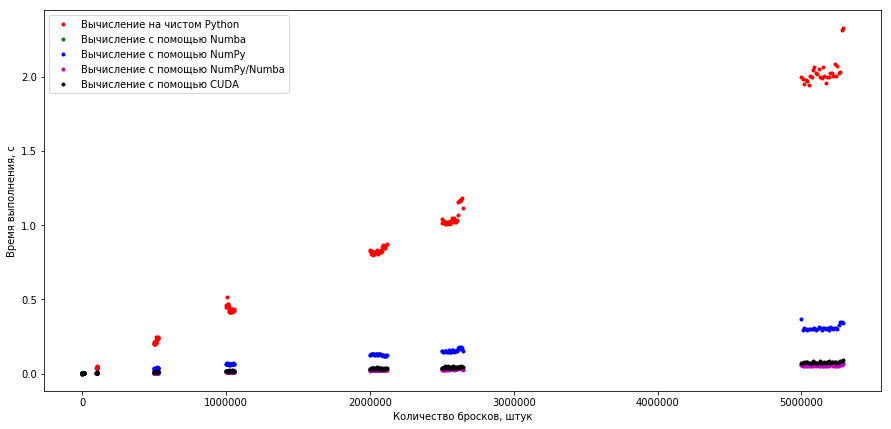

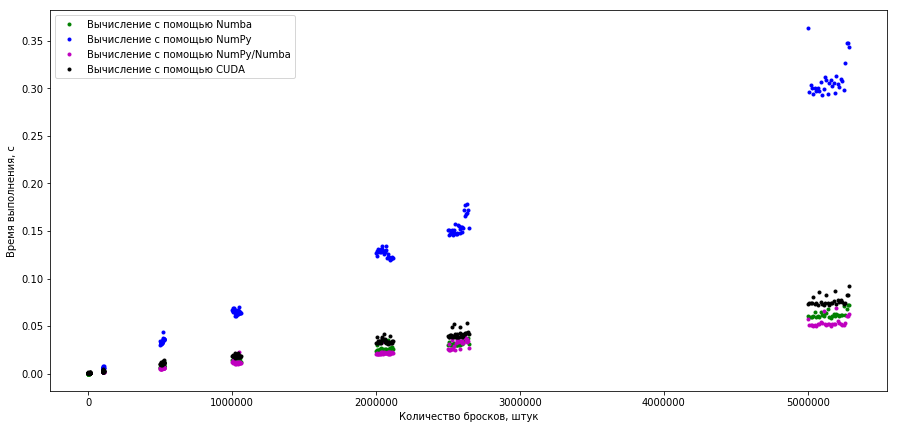

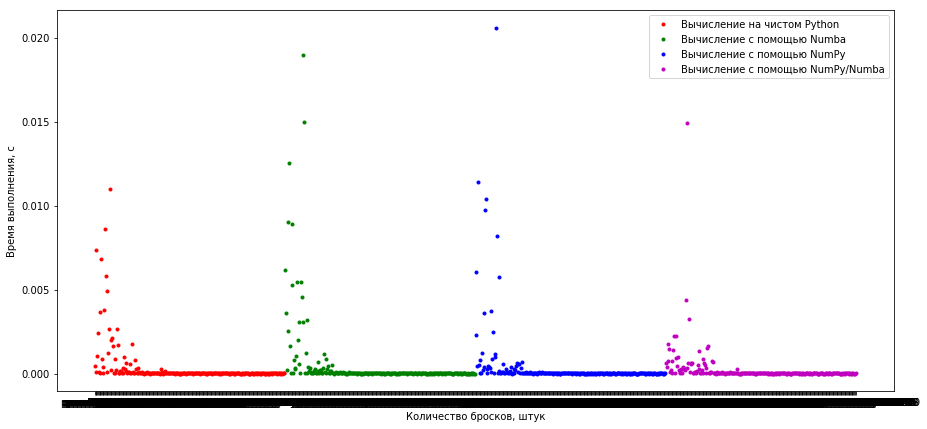

In [70]:
import matplotlib.pyplot as plt

width = 15
height = 7

fig1 = plt.figure(1, figsize=(width, height))
ax1 = fig1.gca()

marks_array = {
    'pure Python':['r.', 'Вычисление на чистом Python'],
    'numba Python':['g.', 'Вычисление с помощью Numba'],
    'numpy Python':['b.', 'Вычисление с помощью NumPy'],
    'numpy/numba Python':['m.', 'Вычисление с помощью NumPy/Numba'],
    'CUDA Python':['k.', 'Вычисление с помощью CUDA']
}

for k, v in result.items():
  ax1.plot(v[0], v[1], marks_array[k][0], label = marks_array[k][1])

plt.ylabel('Время выполнения, c')
plt.xlabel('Количество бросков, штук')
ax1.legend()

fig2 = plt.figure(2, figsize=(width, height))
ax2 = fig2.gca()

for k, v in result.items():
  if k == 'pure Python': continue
  ax2.plot(v[0], v[1], marks_array[k][0], label = marks_array[k][1])

plt.ylabel('Время выполнения, c')
plt.xlabel('Количество бросков, штук')
ax2.legend()

fig3 = plt.figure(3, figsize=(width, height))
ax3 = fig3.gca()

for k, v in pi_array.items():
  if k == 'CUDA Python': continue
  ax3.plot([str(k) + str(n) for n in range(len(v))], v, marks_array[k][0], label = marks_array[k][1])

plt.ylabel('Время выполнения, c')
plt.xlabel('Количество бросков, штук')
ax3.legend()

plt.show()

In [38]:
!conda install --yes line_profiler

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.



In [39]:
%load_ext line_profiler

for k, v in func_array.items():
  print(k)
  %lprun -f v v(100)

ModuleNotFoundError: ignored